In [1]:
%matplotlib inline
import numpy as np
np.random.seed(123)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import sys
from changepoynt.algorithms.sst import SingularSpectrumTransformation
import fastsst

C:\Users\Lucas\PycharmProjects\Changepoynt\venv\lib\site-packages\fastsst\sst.py:199: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  _, s, _ = np.linalg.svd(U_test[:, :n_components].T @
C:\Users\Lucas\PycharmProjects\Changepoynt\venv\lib\site-packages\numba\core\typing\npydecl.py:913: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  warnings.warn(NumbaPerformanceWarning(msg))


In [2]:
# make synthetic step function
x0 = 1 * np.ones(1000) + np.random.rand(1000) * 1
x1 = 3 * np.ones(1000) + np.random.rand(1000) * 2
x2 = 5 * np.ones(1000) + np.random.rand(1000) * 1.5
x = np.hstack([x0, x1, x2])
x += np.random.rand(x.size)

In [3]:
# measure the timings and also plot them
def time_per_window_length(window_length, method, n_iter=10):

    # create the SST object
    sst = SingularSpectrumTransformation(window_length, method=method)

    # compute the scores and add to the timing
    measured_time = 0
    for idx in range(n_iter):
        start = time.time()
        sst.transform(x)
        measured_time += time.time()-start
    return measured_time / n_iter

def measure_time_and_plot():
    # measure the two methods for different timings
    win_lengths_candidates = np.logspace(1,3,5).astype(int)

    # trigger the jit compilation so comparison is fair
    SingularSpectrumTransformation(30, method='ika').transform(x)
    SingularSpectrumTransformation(30, method='svd').transform(x)

    methods = []
    measured_times = []
    window_lengths = []

    for method in ("svd","ika"):
        for wl in win_lengths_candidates:
            print(wl, win_lengths_candidates)
            for j in range(10):
                measured_times.append(time_per_window_length(wl, method=method, n_iter=1))
                methods.append(method)
                window_lengths.append(wl)

    df = pd.DataFrame({"time[s]": measured_times, "method":methods, "window length":window_lengths})
    sns.barplot(x="window length", y="time[s]", hue="method", data=df)

In [12]:
measure_time_and_plot()

10 [  10   31  100  316 1000]
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\Lucas\PycharmProjects\Changepoynt\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Lucas\AppData\Local\Temp\ipykernel_19044\351838254.py", line 1, in <module>
    measure_time_and_plot()
  File "C:\Users\Lucas\AppData\Local\Temp\ipykernel_19044\195302847.py", line 31, in measure_time_and_plot
    measured_times.append(time_per_window_length(wl, method=method, n_iter=1))
  File "C:\Users\Lucas\AppData\Local\Temp\ipykernel_19044\195302847.py", line 11, in time_per_window_length
    sst.transform(x)
  File "c:\users\lucas\pycharmprojects\changepoynt\changepoynt\algorithms\sst.py", line 136, in transform
  File "c:\users\lucas\pycharmprojects\changepoynt\changepoynt\algorithms\sst.py", line 190, in _transform
    # with a norm of one
  File "c:\users\lucas\pycharmprojects\changepoynt\changepoynt\algorithms\sst.py", line 279, in _singular

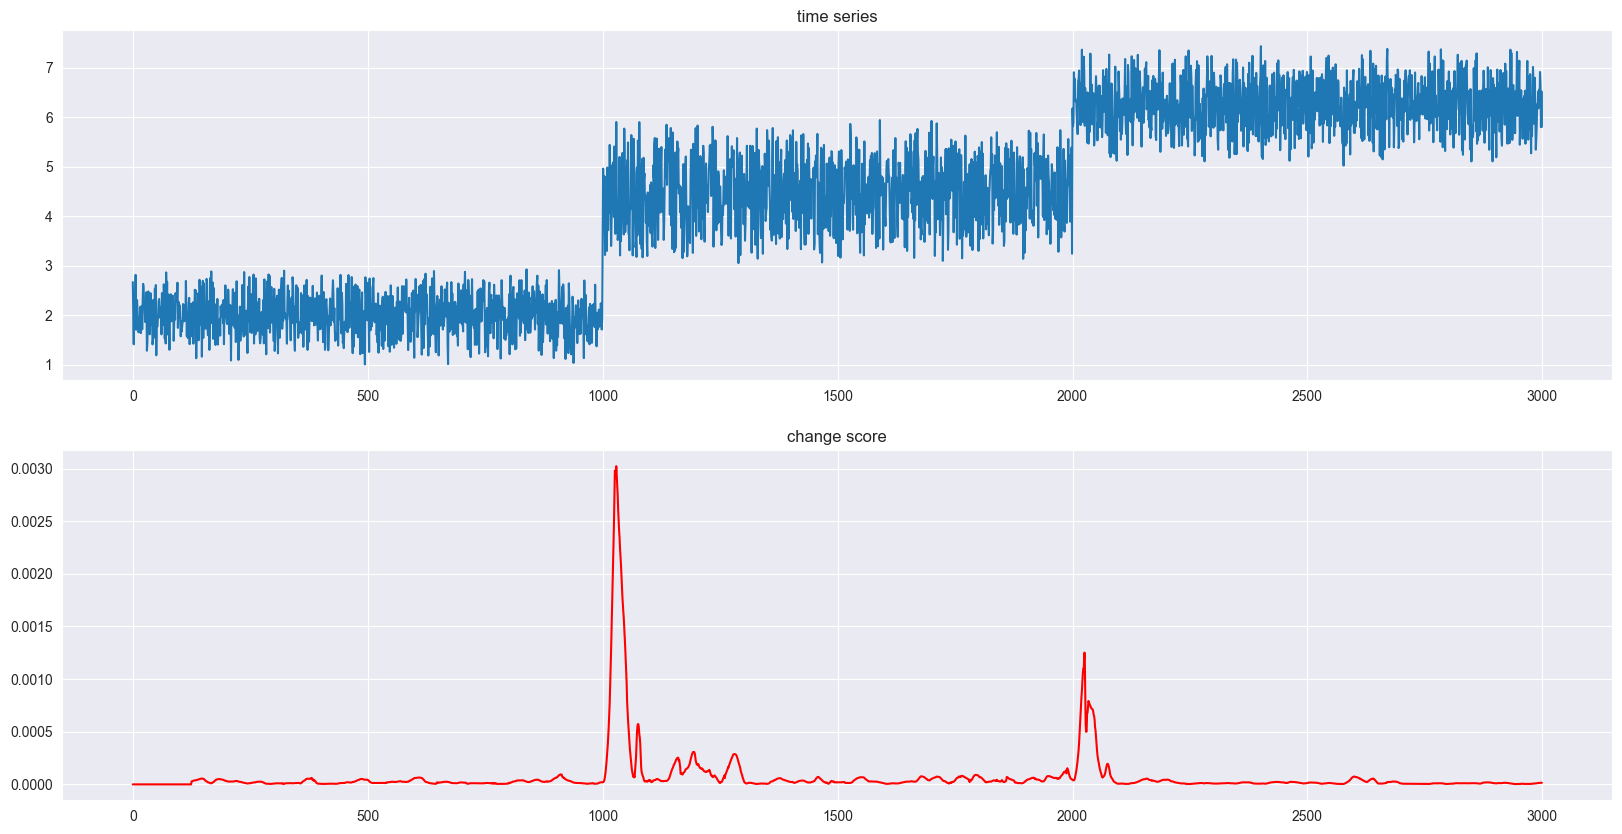

In [4]:
# some plotting utilities
def plot_data_and_score(raw_data, score):
    f, ax = plt.subplots(2,1,figsize=(20,10))
    ax[0].plot(raw_data); ax[0].set_title("time series")
    ax[1].plot(score,"r"); ax[1].set_title("change score")

# compute change score using ika sst
score = SingularSpectrumTransformation(window_length=50, rank=20, method="ika").transform(x)
plot_data_and_score(x,score)

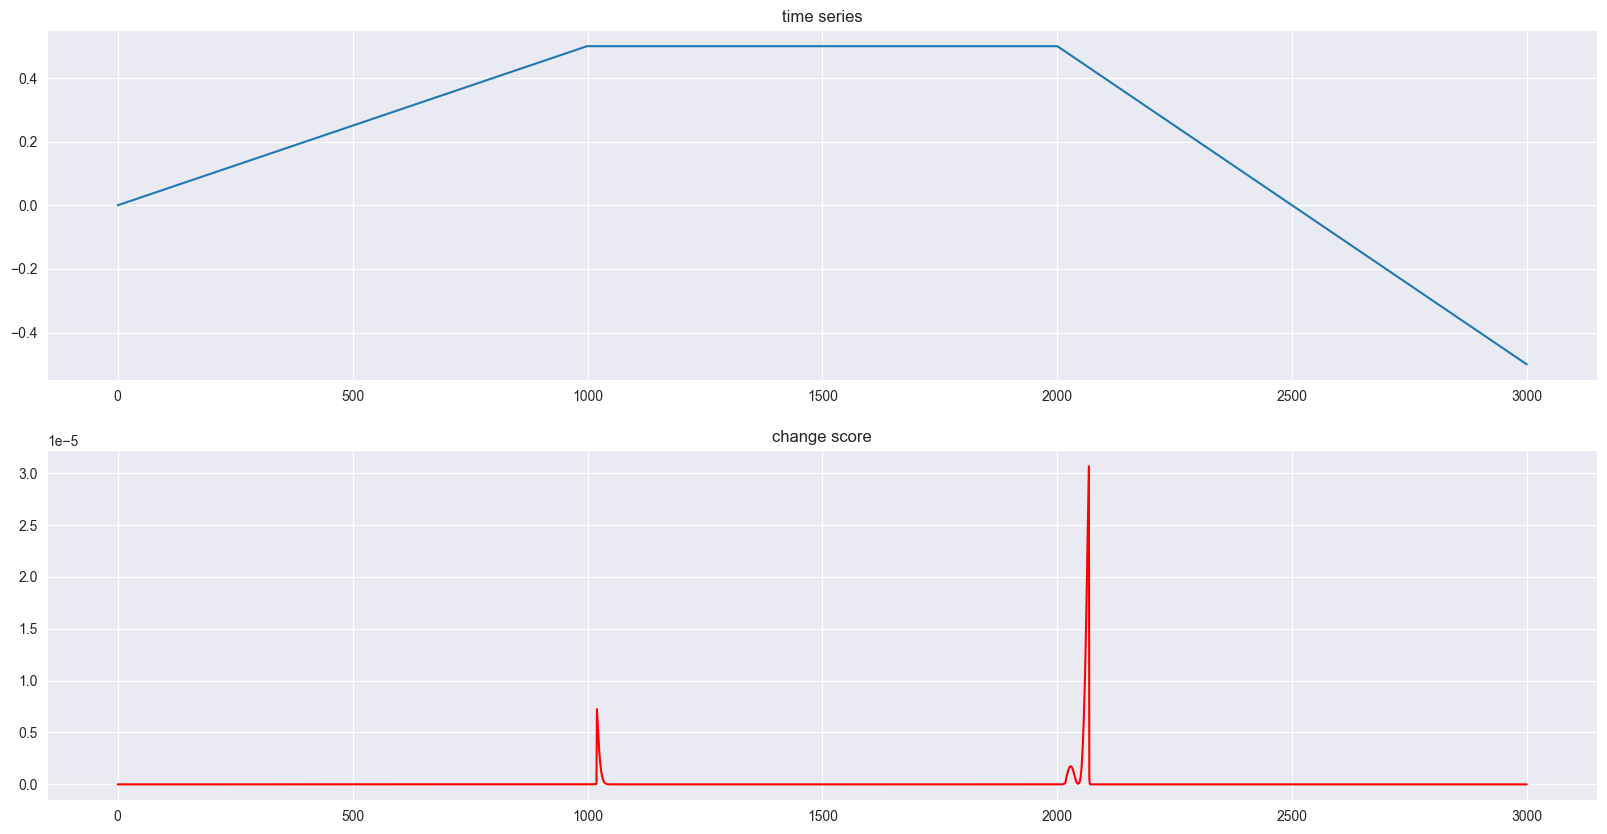

In [5]:
length = 1000
x2 = np.hstack([np.linspace(0, 0.5, num=length), 0.5 * np.ones(length) , np.linspace(0.5, -0.5, num=length)])
# compute change score using sst
score = SingularSpectrumTransformation(window_length=30, rank=5, method="svd").transform(x2)
plot_data_and_score(x2,score)

In [6]:
# synthetic (frequency change)
x0 = np.sin(2*np.pi*1*np.linspace(0,10,1000))
x1 = np.sin(2*np.pi*2*np.linspace(0,10,1000))
x2 = np.sin(2*np.pi*8*np.linspace(0,10,1000))
x3 = np.sin(2*np.pi*4*np.linspace(0,10,1000))
x = np.hstack([x0, x1, x2, x3])
x += np.random.rand(x.size)

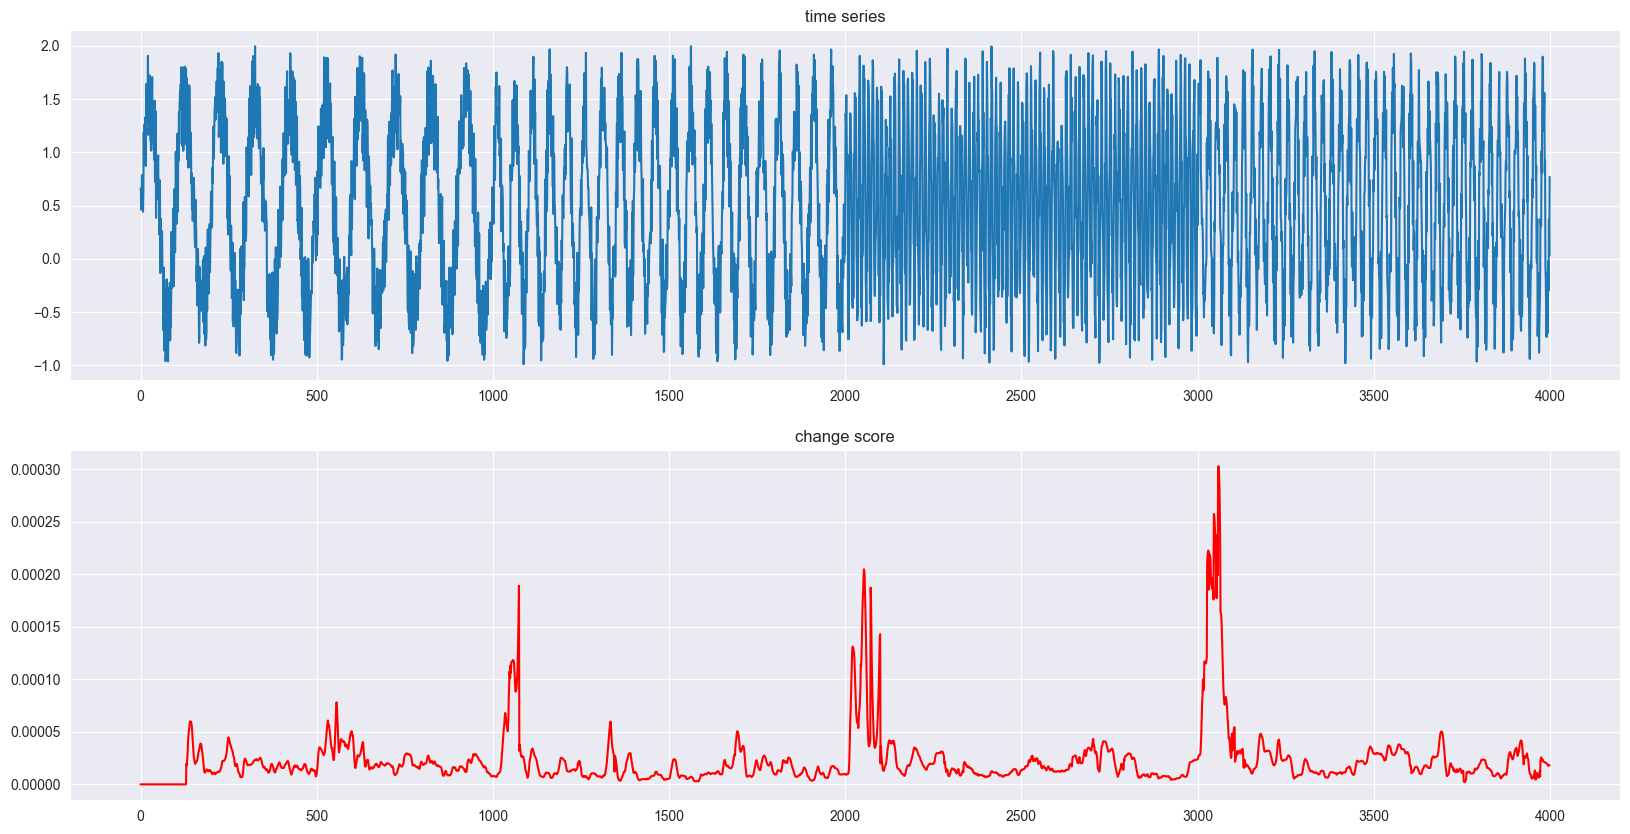

In [7]:
# compute change score using sst
score = SingularSpectrumTransformation(window_length=60, lag=10, rank=5).transform(x)
plot_data_and_score(x,score)

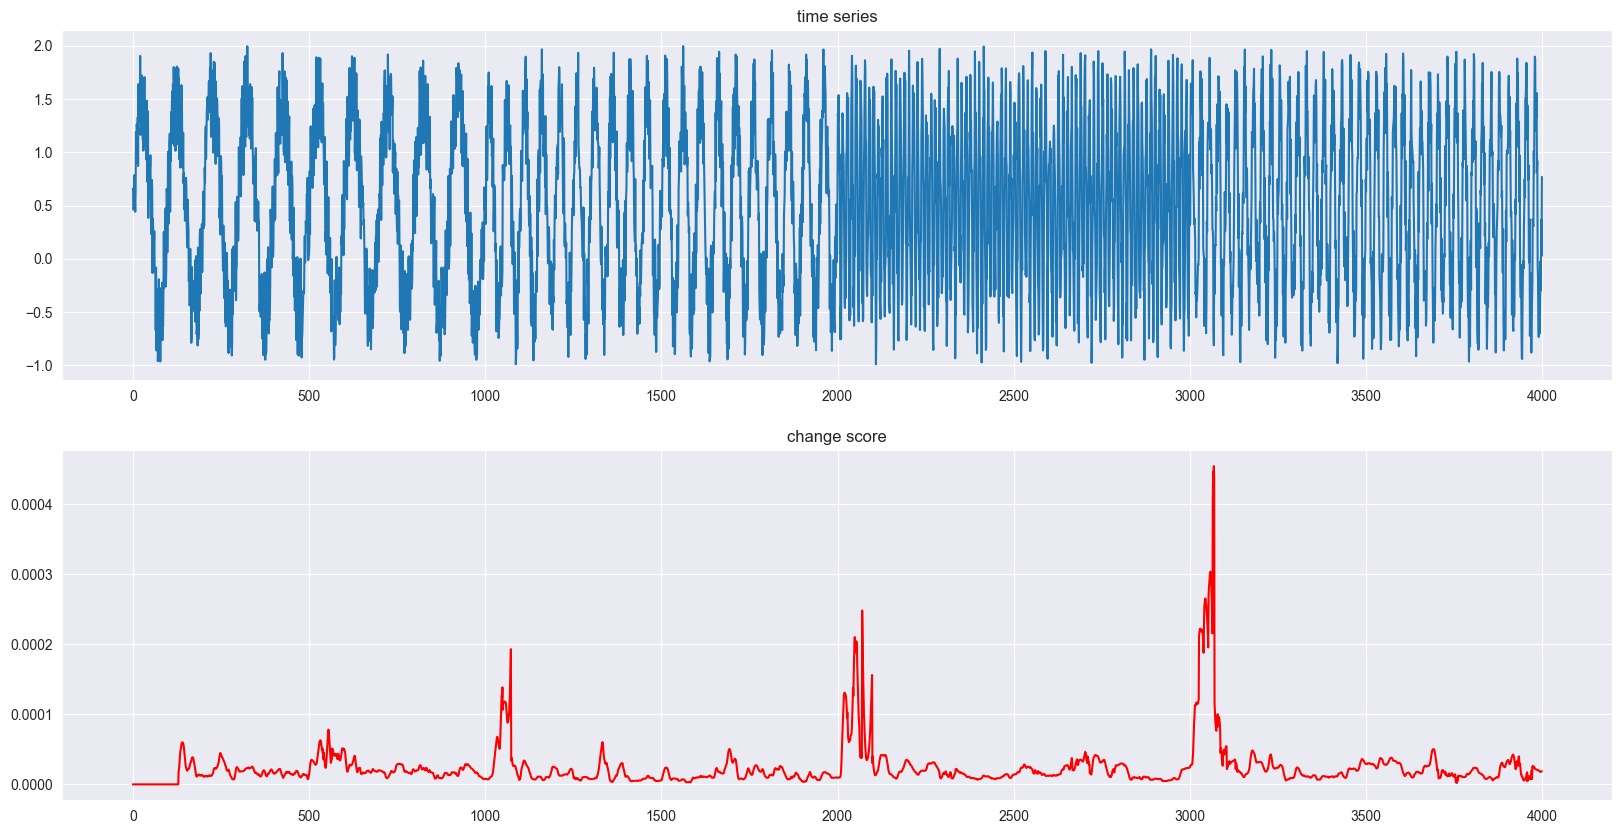

In [8]:
score = fastsst.SingularSpectrumTransformation(win_length=60, lag=10, n_components=5).score_offline(x)
plot_data_and_score(x,score)